In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
import numpy as np
from matplotlib import pyplot as plt
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import random

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

DEBUG=False
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [0]:
def file_to_read(path1,path2):
    file_train_x=open(path1)
    file_train_y=open(path2)
    return file_train_x,file_train_y

In [0]:
file_train_x,file_train_y= file_to_read("gdrive/My Drive/dataset/train.hi","gdrive/My Drive/dataset/train.en")
file_dev_x,file_dev_y= file_to_read("gdrive/My Drive/dataset/dev.hi","gdrive/My Drive/dataset/dev.en")
file_test_x,file_test_y= file_to_read("gdrive/My Drive/dataset/test.hi","gdrive/My Drive/dataset/test.en")


In [0]:
hindi_sent=file_train_x.read().split('\n')[:5000]
eng_sent=file_train_y.read().split('\n')[:5000]
if DEBUG:
    print("-----------------------------")
    print(eng_sent[0])
    print(len(eng_sent))
    print(hindi_sent[0])
    print(len(hindi_sent))

In [0]:
file1=open("gdrive/My Drive/dataset/eng-hindi.txt","w")
for i in range(len(hindi_sent)):
  if DEBUG:
    print("--Writing into file-----")
  file1.write(hindi_sent[i])
  file1.write("\t")
  file1.write(eng_sent[i])
  file1.write("\n")

file1.flush()
file1.close()


In [0]:
SOS_token=0
EOS_token=1
UNK_token=2

In [0]:
class Language:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count ={}
        
        self.index2word = {0: "SOS", 1: "EOS" ,2:"UNK"}
        self.n_words = 3

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words = self.n_words+1
        else:
            self.word2count[word] =self.word2count[word]+1

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    

In [0]:
def readLangs(lang1, lang2, reverse=False):
    
    lines = open('gdrive/My Drive/dataset/%s-%s.txt' % (lang1, lang2), encoding='utf-8').read().strip().split('\n')
    
    pairs = [[s for s in l.split('\t')] for l in lines]
    if DEBUG:
      print("---------------------------------")
      print("Inside ReadLines functions: ")
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Language(lang2)
        output_lang = Language(lang1)
    else:
        input_lang = Language(lang1)
        output_lang = Language(lang2)

    if DEBUG:
      print("--------------------------")
      print("About to return: ")
    return input_lang, output_lang, pairs

In [0]:
def prepareData(lang1, lang2, reverse=False):
    input_lang, output_lang, pairs = readLangs(lang1, lang2, reverse)

    if DEBUG:
      print("lenght of pair", len(pairs))
      
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    
    if DEBUG:
       print("name ",input_lang.name,"words", input_lang.n_words)
       print("name" ,output_lang.name,"words", output_lang.n_words)
    return input_lang, output_lang, pairs


In [0]:
input_lang, output_lang, pairs = prepareData('eng', 'hindi',True)
MAX_LENGTH=1000
if DEBUG:
  print(random.choice(pairs))


In [0]:
class EncoderRNN(nn.Module):

    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()

        self.hidden_size = hidden_size
        if DEBUG:
          print("%------------EncodeRNN class ---------------")
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        if DEBUG:
          print("%------------EncodeRNN class ---------------")
        output, hidden = self.gru(embedded, hidden)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [0]:
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)
        if DEBUG:
          print("%------------DecoderRNN class ---------------")
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        output = self.embedding(input).view(1, 1, -1)
        output = F.relu(output)
        if DEBUG:
          print("%------------DecoderRNN class ---------------")
        output, hidden = self.gru(output, hidden)
        output = self.softmax(self.out(output[0]))
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [0]:
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=MAX_LENGTH):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        if DEBUG:
          print("%------------Atten_DecoderRNN class ---------------")
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)

        attn_weights = F.softmax(
            self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)
        attn_applied = torch.bmm(attn_weights.unsqueeze(0),encoder_outputs.unsqueeze(0))

        output = torch.cat((embedded[0], attn_applied[0]), 1)
        if DEBUG:
          print("%------------Attn_FrowardDecoderRNN class ---------------")
        output = self.attn_combine(output).unsqueeze(0)

        output = F.relu(output)
        output, hidden = self.gru(output, hidden)

        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attn_weights

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [0]:
def indexesFromSentence(lang, sentence):
  if DEBUG:
    print("About to return functions:1 ")
  return [lang.word2index[word] if word in lang.word2index else UNK_token for word in sentence.split(' ')]


def tensorFromSentence(lang, sentence):
  if DEBUG:
    print("About to return functions:2 ")
  indexes = indexesFromSentence(lang, sentence)
  indexes.append(EOS_token)
  return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)


def tensorsFromPair(pair):
  if DEBUG:
    print("About to return functions:3 ")
  input_tensor = tensorFromSentence(input_lang, pair[0])
  target_tensor = tensorFromSentence(output_lang, pair[1])
  return (input_tensor, target_tensor)

In [0]:
teacher_forcing_ratio = 0.4

def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    if DEBUG:
      print(input_length)
    target_length = target_tensor.size(0)
    if DEBUG:
      print(input_length)
      print(target_length)
    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)
    if DEBUG:
      print(encoder_outputs)

    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]

    decoder_input = torch.tensor([[SOS_token]], device=device)

    decoder_hidden = encoder_hidden

    use_teacher_forcing = False
    if random.random() < teacher_forcing_ratio:
      use_teacher_forcing=True
    else:
      use_teacher_forcing=False

    if use_teacher_forcing:
        for di in range(target_length):
            decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden)
            loss =loss+ criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di] 

    else:
        for di in range(target_length):
            decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()

            loss =loss+ criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token:
                break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length

In [0]:
def trainIters(encoder1, decoder1, n_iters, printEvery, plot_every=100, learning_rate=0.02):
    start = time.time()
    plot_losses = []
    print_loss_total = 0 
    if DEBUG:
      print("Inside TrainIters")
      print(print_loss_total)
    plot_loss_total = 0  

    encoder_optimizer = optim.SGD(encoder1.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder1.parameters(), lr=learning_rate)
    training_pairs = [tensorsFromPair(random.choice(pairs))
                      for i in range(n_iters)]
    criterion = nn.NLLLoss()

    for iter in range(1, n_iters + 1):
        training_pair = training_pairs[iter - 1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]

        loss = train(input_tensor, target_tensor, encoder1,decoder1, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total = print_loss_total+ loss
        plot_loss_total =plot_loss_total+ loss
        if DEBUG:
          print("Total loss",plot_loss_total)
          
        if iter % printEvery == 0:
            print_loss_avg = print_loss_total / printEvery
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters),iter, iter / n_iters * 100, print_loss_avg))
            if DEBUG:
              print("Inside print")
              print(print_loss_total)

        if iter % printEvery == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0


In [0]:

def evaluate(encoder, decoder, sentence, max_length=MAX_LENGTH):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei],
                                                     encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS

        decoder_hidden = encoder_hidden

        decoded_words = []
        decoder_attentions = torch.zeros(max_length, max_length)

        for di in range(max_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            decoder_attentions[di] = decoder_attention.data
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(output_lang.index2word[topi.item()])

            decoder_input = topi.squeeze().detach()

        
        return decoded_words, decoder_attentions[:di + 1]

In [0]:
hidden_size = 256
name1="gdrive/My Drive/dataset/atten_encoder1"
name2= "gdrive/My Drive/dataset/atten_decoder1"
iterations=50000
dropout=0.1

In [58]:

atten_encoder1 = EncoderRNN(input_lang.n_words, hidden_size).to(device)
attn_decoder1 = AttnDecoderRNN(hidden_size, output_lang.n_words, dropout_p=0.1).to(device)

trainIters(atten_encoder1,attn_decoder1, iterations, print_every=5000)

3m 11s (- 28m 40s) (5000 10%) 4.9238
6m 32s (- 26m 9s) (10000 20%) 4.8630
10m 1s (- 23m 24s) (15000 30%) 4.7969
13m 32s (- 20m 18s) (20000 40%) 4.5207
17m 11s (- 17m 11s) (25000 50%) 4.2961
20m 57s (- 13m 58s) (30000 60%) 4.0388
24m 39s (- 10m 34s) (35000 70%) 3.8619
28m 24s (- 7m 6s) (40000 80%) 3.6704
32m 8s (- 3m 34s) (45000 90%) 3.5761
35m 46s (- 0m 0s) (50000 100%) 3.4379


Save the model

In [0]:
# torch.save(atten_encoder1.state_dict(),name1)
# device = torch.device('cpu')
# torch.save(attn_decoder1.state_dict(),name2)


Load the model

In [22]:

encoder_model = EncoderRNN(input_lang.n_words, hidden_size).to(device)
encoder_model.load_state_dict(torch.load(name1, map_location=device))

atten_decoder_model = AttnDecoderRNN(hidden_size, output_lang.n_words, dropout_p=0.1).to(device)
atten_decoder_model.load_state_dict(torch.load(name2, map_location=device))

<All keys matched successfully>

In [0]:
hindi_dev_sent=file_dev_x.read().split('\n')
eng_dev_sent=file_dev_y.read().split('\n')
hindi_test_sent=file_test_x.read().split('\n')
eng_test_sent=file_test_y.read().split('\n')
if DEBUG:
    print(eng_dev_sent[0])
    print(len(eng_dev_sent))
    print(hindi_dev_sent[0])
    print(len(hindi_dev_sent))
    print(eng_test_sent[0])
    print(len(eng_test_sent))
    print(hindi_test_sent[0])
    print(len(hindi_test_sent))

['गाँठ', 'या', 'या', 'या', 'रंग', 'या', 'है', '।', '।', '।', '।', '<EOS>']


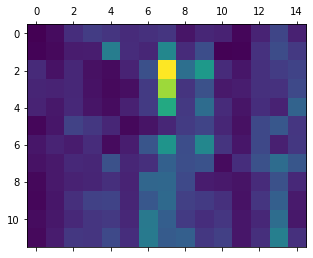

In [24]:
output_words,atten= evaluate(encoder_model, atten_decoder_model, "The knot can be of normal color or else of black color .")

print(output_words)
plt.matshow((atten.numpy())[:,:15])

In [26]:
from nltk.translate.bleu_score import sentence_bleu
from nltk.translate.bleu_score import SmoothingFunction

for i in eng_test_sent[15:20]:
  
  print(i)
  output_words,tens= evaluate(encoder_model, atten_decoder_model,i)
  print(output_words)
  # plt.matshow((tens.numpy())[:,:10])
  # score = sentence_bleu(i, output_words)
  smoothie = SmoothingFunction().method4
  score = sentence_bleu(i, output_words, smoothing_function=smoothie)
  print("bleu Score : ",score)


Saliva is formed by chewing the chewing gum .
['रोगी', 'से', 'से', 'से', 'का', 'है', '।', '।', '<EOS>']
bleu Score :  0.045
Chewing gum helps in keeping the teeth clean .
['दाँत', 'बच्चा', 'बैक्टीरिया', 'को', 'अपनी', 'मदद', 'करता', '।', '<EOS>']
bleu Score :  0.046
Sugared chewing gum is not supposed to be good for health .
['स्वास्थ्य', 'के', 'लिए', 'के', 'लिए', 'के', 'के', 'लिए', 'लिए', 'के', 'के', 'के', 'लिए', 'लिए', 'के', 'लिए', 'के', '<EOS>']
bleu Score :  0.059000000000000004
That is why dentists do not suggest chewing sugared chewing gum .
['हर्निया', 'को', 'स्वस्थ', 'नहीं', 'साथ', '।', 'है', '।', '।', '।', '<EOS>']
bleu Score :  0.065
Get the teeth checked-up regularly .
['दाँतों', 'को', 'दाँतों', 'दाँत', 'दाँत', '।', 'से', '।', '।', '<EOS>']
bleu Score :  0.036000000000000004
